In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf

In [2]:
csv_path= '../data/Data.csv'
df = pd.read_csv(csv_path, sep='^')
df.head()

,Date,demand,solar,wind,price
0,2014-01-01 00:00:00,26252.0,3.5,10790.0,20.02
1,2014-01-01 01:00:00,24040.0,0.0,10885.0,10.34
2,2014-01-01 02:00:00,22829.0,0.0,10984.0,5.35
3,2014-01-01 03:00:00,21816.0,0.5,10680.0,5.00
4,2014-01-01 04:00:00,21439.0,2.2,10605.0,0.50


In [3]:
TRAIN_SPLIT = 40000
tf.random.set_seed(13)

In [4]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [5]:
columns = ['demand', 'solar', 'wind', 'price', 'Day sin', 'Day cos', 'Year sin',
       'Year cos']

In [6]:
features = df[columns]
features.head()

,demand,solar,wind,price,Day sin,Day cos,Year sin,Year cos
0,26252.0,3.5,10790.0,20.02,-1.067931e-11,1.000000,0.005677,0.999984
1,24040.0,0.0,10885.0,10.34,2.588190e-01,0.965926,0.006394,0.999980
2,22829.0,0.0,10984.0,5.35,5.000000e-01,0.866025,0.007110,0.999975
3,21816.0,0.5,10680.0,5.00,7.071068e-01,0.707107,0.007827,0.999969
4,21439.0,2.2,10605.0,0.50,8.660254e-01,0.500000,0.008544,0.999963


In [7]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [8]:
def multivariate_window(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [10]:
def train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def time_steps_creation(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = time_steps_creation(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 3]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [56]:
past_history = 144
future_target = 12
STEP = 1
SINGLE_STEP = False

x_train_multi, y_train_multi = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=0, end_index=TRAIN_SPLIT, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)
x_val_multi, y_val_multi = multivariate_window(dataset=dataset, target=dataset[:, 3], 
  start_index=TRAIN_SPLIT, end_index=None, history_size=past_history,
  target_size=future_target, step=STEP, single_step=SINGLE_STEP)

In [57]:
y_train_multi = y_train_multi.reshape((y_train_multi.shape[0],y_train_multi.shape[1], 1))
y_val_multi = y_val_multi.reshape((y_val_multi.shape[0],y_val_multi.shape[1], 1))

In [61]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

# Sequence to Sequence models

### Simple LSTM Encoder-Decoder

In [63]:

# MODEL
seq_to_seq_model = tf.keras.models.Sequential()
seq_to_seq_model.add(tf.keras.layers.LSTM(64,activation='relu',
                                           input_shape=x_train_multi.shape[-2:]))
seq_to_seq_model.add(tf.keras.layers.RepeatVector(future_target))
seq_to_seq_model.add(tf.keras.layers.LSTM(64,activation='relu',
                                           return_sequences=True))
seq_to_seq_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))
seq_to_seq_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

seq_to_seq_model.compile(optimizer='adam', loss='mae')



In [41]:
seq_to_seq_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                18688     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 12, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 12, 32)            2080      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 12, 1)             33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


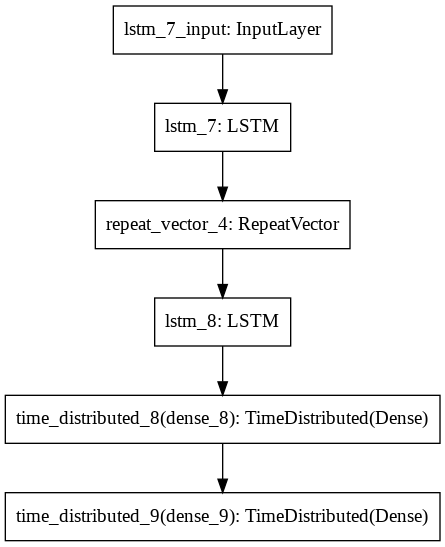

In [42]:
tf.keras.utils.plot_model(
    seq_to_seq_model, to_file='s2slstm.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [64]:
EPOCHS = 20
EVALUATION_INTERVAL = 200


seq_to_seq_model_history = seq_to_seq_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,)

Epoch 1/20
200/200 [==============================] - 15s 73ms/step - loss: 0.5958 - val_loss: 0.3590
Epoch 2/20
200/200 [==============================] - 15s 75ms/step - loss: 0.4328 - val_loss: 0.3445
Epoch 3/20
200/200 [==============================] - 15s 76ms/step - loss: 0.3727 - val_loss: 0.2608
Epoch 4/20
200/200 [==============================] - 16s 80ms/step - loss: 0.3393 - val_loss: 0.3083
Epoch 5/20
200/200 [==============================] - 17s 83ms/step - loss: 0.2849 - val_loss: 0.2722
Epoch 6/20
200/200 [==============================] - 19s 93ms/step - loss: 0.2837 - val_loss: 0.2376
Epoch 7/20
200/200 [==============================] - 16s 82ms/step - loss: 0.2603 - val_loss: 0.2064
Epoch 8/20
200/200 [==============================] - 15s 77ms/step - loss: 0.2474 - val_loss: 0.2372
Epoch 9/20
200/200 [==============================] - 15s 74ms/step - loss: 0.2650 - val_loss: 0.2294
Epoch 10/20
200/200 [==============================] - 14s 72ms/step - loss: 0.243

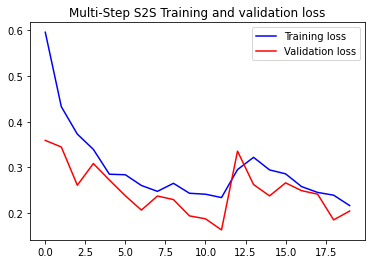

1000/1000 [==============================] - 15s 15ms/step - loss: 0.2295
MAE for LSTM S2S is 0.2295


In [65]:
train_history(seq_to_seq_model_history, 'Multi-Step S2S Training and validation loss')

mae = seq_to_seq_model.evaluate(val_data_multi, steps=1000)

print("MAE for LSTM S2S is %.4f" %mae)

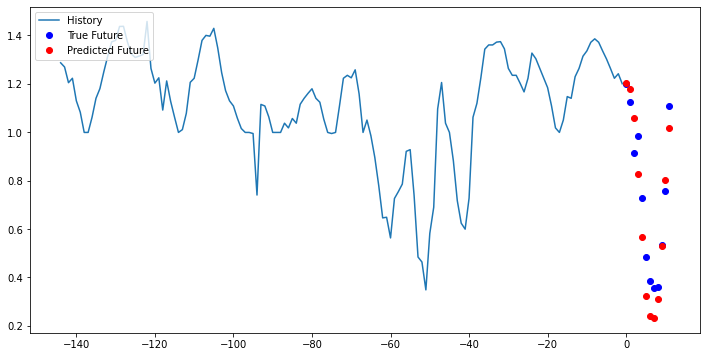

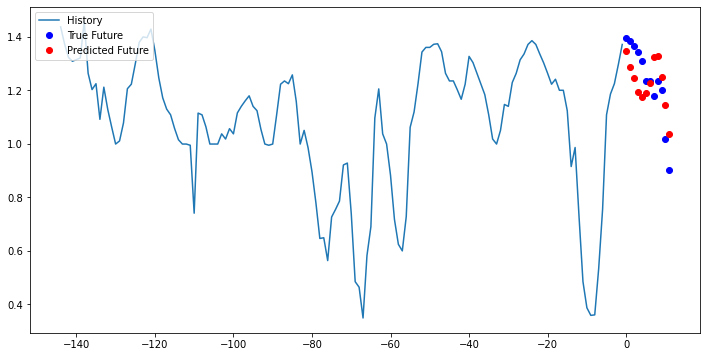

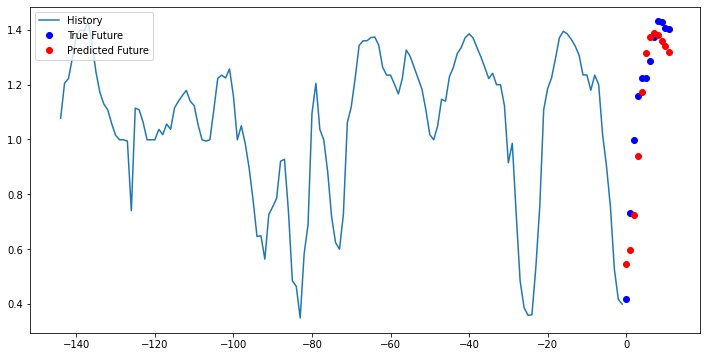

In [66]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], seq_to_seq_model.predict(x)[0])

In [67]:
seq_to_seq_model.save('seq2seq.h5')

### CNN-LSTM Encoder-Decoder

In [68]:
# MODEL
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=x_train_multi.shape[-2:]))
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.RepeatVector(future_target))
cnn_model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
cnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))
cnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
cnn_model.compile(loss='mse', optimizer='adam')

In [69]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 142, 64)           1600      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 140, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4480)              0         
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 12, 4480)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 12, 64)            1163520   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 12, 32)           

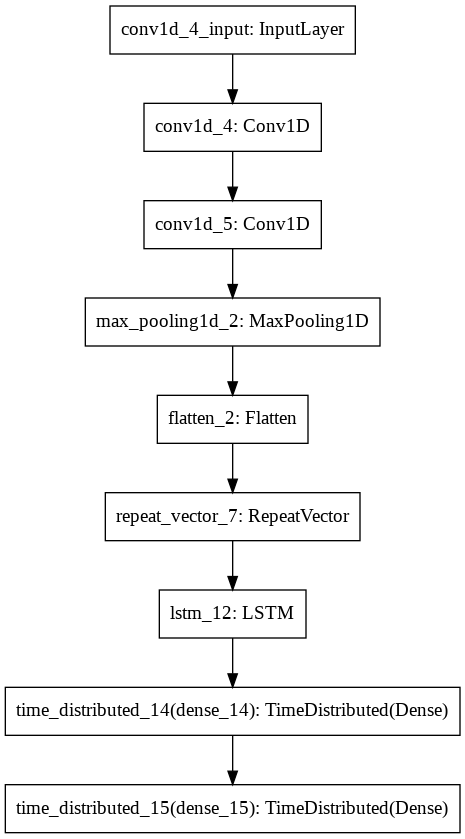

In [70]:
tf.keras.utils.plot_model(
    cnn_model, to_file='s2slcnn.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [72]:
EPOCHS = 20
EVALUATION_INTERVAL = 200

cnn_model_history = cnn_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,)

Epoch 1/20
200/200 [==============================] - 21s 104ms/step - loss: 0.5855 - val_loss: 0.2463
Epoch 2/20
200/200 [==============================] - 19s 97ms/step - loss: 0.3802 - val_loss: 0.1571
Epoch 3/20
200/200 [==============================] - 19s 96ms/step - loss: 0.2826 - val_loss: 0.1425
Epoch 4/20
200/200 [==============================] - 19s 96ms/step - loss: 0.1980 - val_loss: 0.2531
Epoch 5/20
200/200 [==============================] - 19s 96ms/step - loss: 0.1592 - val_loss: 0.0991
Epoch 6/20
200/200 [==============================] - 19s 96ms/step - loss: 0.1686 - val_loss: 0.0614
Epoch 7/20
200/200 [==============================] - 19s 95ms/step - loss: 0.1354 - val_loss: 0.1089
Epoch 8/20
200/200 [==============================] - 19s 96ms/step - loss: 0.1155 - val_loss: 0.0652
Epoch 9/20
200/200 [==============================] - 20s 98ms/step - loss: 0.1367 - val_loss: 0.0805
Epoch 10/20
200/200 [==============================] - 19s 95ms/step - loss: 0.11

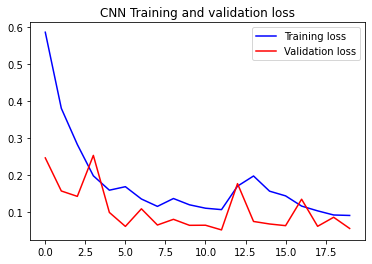

1000/1000 [==============================] - 17s 17ms/step - loss: 0.1061
MAE for CNN S2S is 0.1061


In [73]:
train_history(cnn_model_history, 'CNN Training and validation loss')

mae = cnn_model.evaluate(val_data_multi, steps=1000)

print("MAE for CNN S2S is %.4f" %mae)

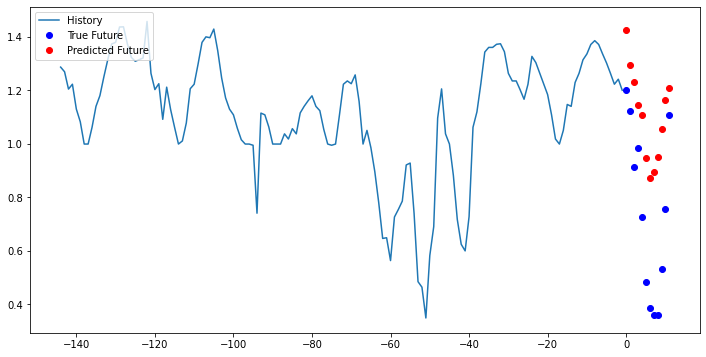

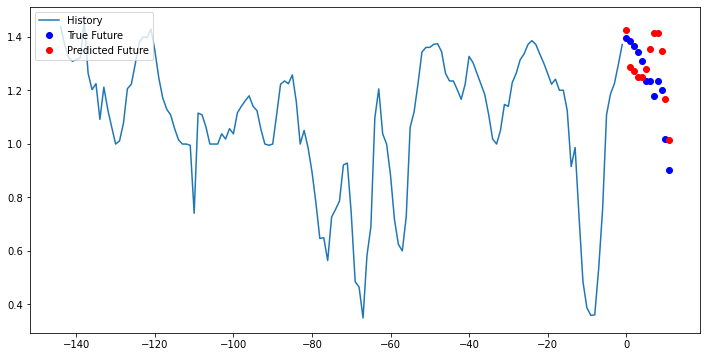

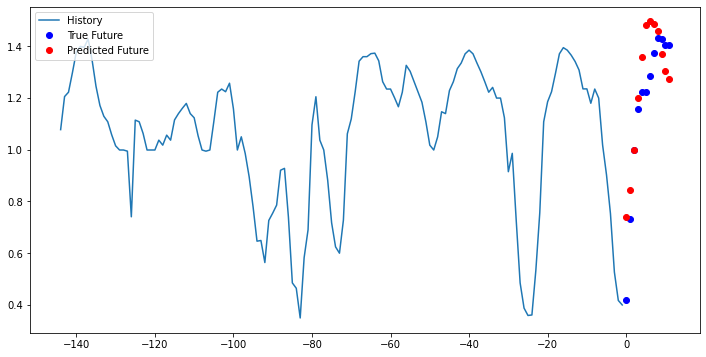

In [74]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], cnn_model.predict(x)[0])

In [75]:
cnn_model.save('seq2seqcnn.h5')